In [1]:
# To run this notebook in Google Colab, uncomment the following line to
# install all required packages.
#!pip install git+https://github.com/simonpf/at652

# Practical example: Using a Multi-Layer Perceptron to retrieve precipitation

- The previous section introduced the basics of neural network and how to implement them using PyTorch
- With this knowledge you are able to design a neural-network-based precipitation retrieval.


## Motivation

 - Satellite observations allow us to observe the global distribution of precipitation
 - However, there is no direct relationship between the satellite observations and the corresponding precipitation at the surface

![Machine learning for precipitation retrievals](../figures/retrieval.png)

## The IPWG ML benchmark dataset

- The IPWG Satellite Precipitation Retrieval (SPR) benchmark dataset was developed by the machine-learning working group of the International Precipitation Working Group (IPWG)
- The dataset consists of satellite observations collocated with ground-based radar observations over CONUS

<div style="text-align: center;">
  <img src="../figures/ipwgml.png" alt="Example scene from the IPWG precipitation retrieval benchmark dataset" width="800"/>
</div>

### The ``ipwgml`` package

- The dataset can be accessed conveniently through the ``ipwgml`` Python package
- More detailed documentation for the dataset is available at [ipwgml.readthedocs.org](ipwgml.readthedocs.org)
- To install the package in your current environment run:

In [2]:
# Uncomment and excute the following line if you have not yet install the ipwgml package.
#!pip install git+https://github.com/simonpf/ipwgml

### Getting and loading the data
 - The ``ipwgml`` package provides the ``download_dataset`` function to download the SPR data.
 - The dataset is split into input data consisting of observations from different remote-sensing sensor and corresponding target data derived from groun-based precipitation radars.

In [3]:
import ipwgml
from ipwgml.data import download_dataset
import xarray as xr


# We download the validation split for now because it is smaller.
# Note that testing is performed on a completerly independent dataset.
files = download_dataset("spr", "gmi", "gmi", "validation", "on_swath", "tabular")
input_data = xr.load_dataset(files["gmi"][0], engine="h5netcdf")
target_data = xr.load_dataset(files["target"][0], engine="h5netcdf")

### Keeping only high-quality precipitation estimates

- The target data contains a radar-quality index (rangin from 0 to 1) providing a quantitative measure of the quality of the precipitation estimates
- For this example, we will use only samples with a high radar quality index.

In [4]:
valid_samples = target_data.radar_quality_index > 0.8
input_data = input_data[{"samples": valid_samples}]
target_data = target_data[{"samples": valid_samples}]

## Expoloratory data analysis

- Exploratory data analysis (EDA) should be performed whenever you are working with a new dataset.
- The dataset determines what your model learns so it is crucial to understand its properties.
- Proper EDA will also help you data issues that may cause your training to fail.
- Things to look out for:
  - NAN values: These need to be replaced for training
  - Suspicious mininmum and maximum values, such as -9999, which may be a flag for missing values.
  - Unphysical values, such as negative precipitation rates.

### Input data

In [5]:
import pandas as pd

channel_stats = []
for channel in range(input_data.channel.size):
    channel_data = input_data.observations[{"channel": channel}].to_dataframe()
    channel_data = channel_data.rename({"observations": f"Channel {channel + 1}"}, axis=1)
    channel_stats.append(channel_data)
    
pd.concat(channel_stats, axis=1).describe()

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13
count,3.258979e+06,3.258974e+06,3.258747e+06,3.258552e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,3.258987e+06,2.678759e+06,2.678759e+06,2.678759e+06,2.678759e+06
mean,2.609613e+02,2.441096e+02,2.650483e+02,2.514391e+02,2.679727e+02,2.665856e+02,2.549959e+02,2.708065e+02,2.640270e+02,2.721501e+02,2.704423e+02,2.582835e+02,2.674665e+02
std,3.036579e+01,4.813712e+01,2.555046e+01,4.193598e+01,2.042495e+01,2.066952e+01,3.556570e+01,1.679146e+01,2.342350e+01,1.450469e+01,1.637944e+01,8.247438e+00,1.036605e+01
min,1.561100e+02,7.953000e+01,1.711700e+02,9.000000e+01,1.541800e+02,1.038100e+02,1.020800e+02,6.156000e+01,6.011000e+01,6.926000e+01,6.704000e+01,7.259000e+01,7.092000e+01
25%,2.585500e+02,2.443200e+02,2.610000e+02,2.502700e+02,2.620500e+02,2.616000e+02,2.528400e+02,2.644900e+02,2.577700e+02,2.673700e+02,2.653400e+02,2.531600e+02,2.631000e+02
50%,2.682600e+02,2.590100e+02,2.709600e+02,2.641900e+02,2.720900e+02,2.713400e+02,2.659800e+02,2.737400e+02,2.699000e+02,2.751000e+02,2.743000e+02,2.579400e+02,2.682800e+02
75%,2.782700e+02,2.704100e+02,2.801200e+02,2.746400e+02,2.810000e+02,2.796100e+02,2.753300e+02,2.817700e+02,2.792300e+02,2.809100e+02,2.806100e+02,2.633300e+02,2.733000e+02
max,3.479400e+02,3.497600e+02,3.498700e+02,3.499700e+02,3.141500e+02,3.179700e+02,3.060000e+02,3.130600e+02,3.084300e+02,3.093700e+02,3.061900e+02,2.855100e+02,2.984900e+02


### Target data

In [6]:
target_data.surface_precip.to_dataframe().describe()

,surface_precip
count,3.258987e+06
mean,1.011049e-01
std,9.690891e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.077300e+02


### Correlations

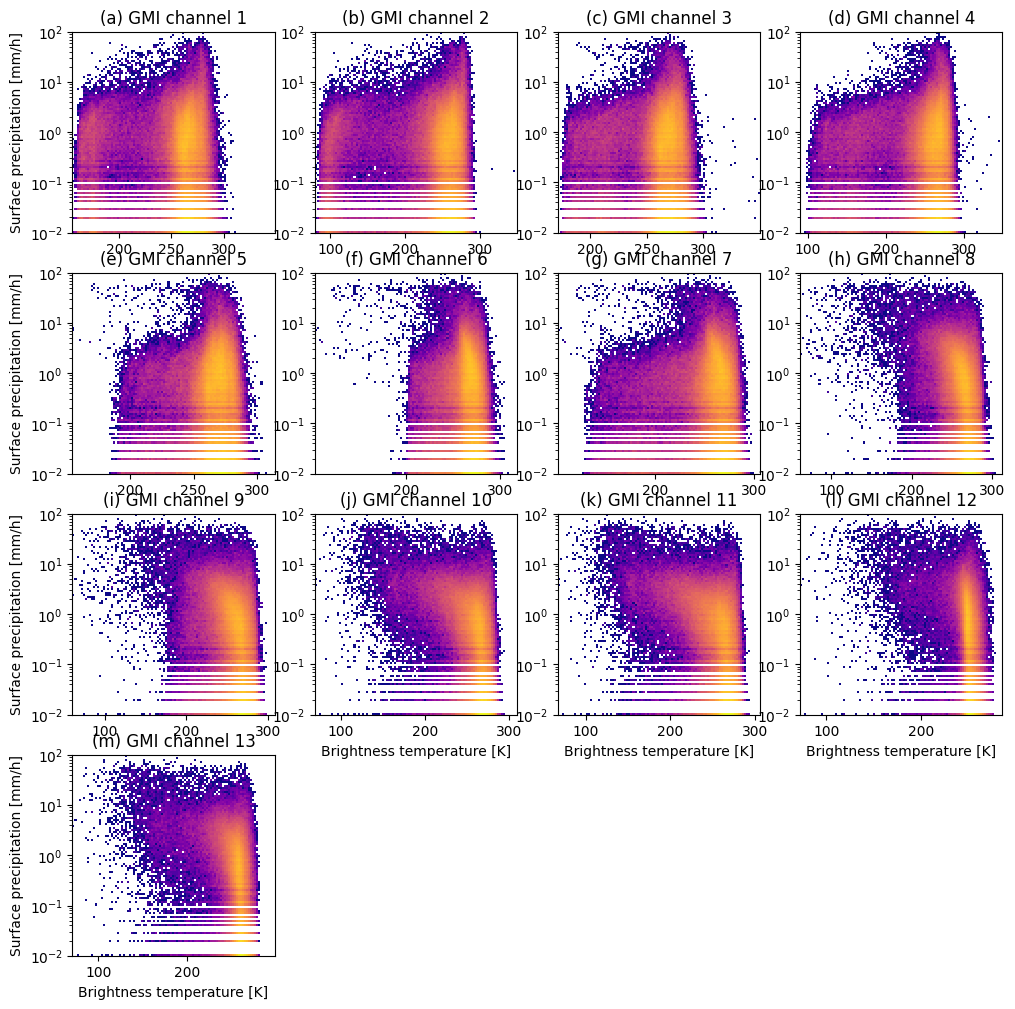

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import numpy as np

n_rows = 4
n_cols = 4
fig = plt.figure(figsize=(3 * n_rows, 3 * n_cols))
gs = GridSpec(n_rows, n_cols)

surface_precip = target_data["surface_precip"].data
surface_precip_bins = np.logspace(-2, 2, 101)

for row_ind in range(4):
    for col_ind in range(4):
        channel_ind = row_ind * 4 + col_ind
        
        if channel_ind > 12:
            continue
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        obs = input_data["observations"][{"channel": channel_ind}]
        obs_bins = np.linspace(obs.min(), obs.max(), 101)
        cts = np.histogram2d(obs, surface_precip, bins=(obs_bins, surface_precip_bins))[0]

        ax.pcolormesh(obs_bins, surface_precip_bins, cts.T, norm=LogNorm(), cmap="plasma")
        ax.set_yscale("log")

        ax.set_title(f"({chr(ord('a') + channel_ind)}) GMI channel {channel_ind + 1}")

        if col_ind == 0:
            ax.set_ylabel("Surface precipitation [mm/h]")

        if channel_ind > 8:
            ax.set_xlabel("Brightness temperature [K]")
        

## Training a simple neural network retrieval

- Below we will use the techniques we learned to train a very basic fully-connected neural network to retrieva surface precipitation

### Preparing the data

- It is common to normalize the input data for neural networks. Below we use min-max normalization to map all input features to the range [-1, 1]
- Neural networks can't handle NAN values. So we replace them with -1.5
- We also convert all input data to torch.Tensors and 32-bit floating point types.

In [8]:
import torch 

obs_min = input_data.observations.min("samples")
obs_max = input_data.observations.max("samples")

obs_n = -1.0  + (input_data.observations - obs_min) / (obs_max - obs_min)
obs = torch.tensor(obs_n.data).to(torch.float32)
obs = torch.nan_to_num(obs, nan=-1.5)

obs = torch.tensor(obs.data).to(torch.float32)
surface_precip = torch.tensor(target_data.surface_precip.data).to(torch.float32)

/tmp/ipykernel_6052/2589277915.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs.data).to(torch.float32)


#### Training and validation datasets

- This time, we split the data into training and validation dataset so that we can use the validation dataset to monitor training progress.

In [9]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(
    obs.reshape(-1, 13),
    surface_precip.reshape(-1, 1)
)
training_data, validation_data = random_split(dataset, (0.8, 0.2))
training_loader = DataLoader(training_data, num_workers=4, batch_size=1024, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=4, batch_size=1024, shuffle=True)

### The neural network

- We use a similar neural network as before but adjust the number of input features to match the number of channels of the GMI sensor.

In [10]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(13, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

### Training loop


In [ ]:
from tqdm import tqdm
from torch.optim import SGD

loss_fn = nn.MSELoss()
optimizer = SGD(mlp.parameters(), lr=5e-2)

n_epochs = 100

for epoch_index in range(n_epochs):

    tot_loss = 0.0
    n_samples = 0
    
    for x_b, y_b in tqdm(training_loader):
        
        loss = loss_fn(y_b, mlp(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    val_loss = 0
    for x_b, y_b in validation_loader:
        with torch.no_grad():
            y_pred = mlp(x_b)
            val_loss += loss_fn(y_b, y_pred).item()

    print(f"Epoch {epoch_index}, Validation loss: {val_loss / len(validation_loader)}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:14<00:00, 171.97it/s]


Epoch 0, Validation loss: 0.8501835664737168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:15<00:00, 165.74it/s]


Epoch 1, Validation loss: 0.6990705287578155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:16<00:00, 155.10it/s]


Epoch 2, Validation loss: 0.6727974279206158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:18<00:00, 141.18it/s]


Epoch 3, Validation loss: 0.7046800791234761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 107.66it/s]


Epoch 4, Validation loss: 0.6485492894879222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 108.76it/s]


Epoch 5, Validation loss: 0.6513169138009545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 123.63it/s]


Epoch 6, Validation loss: 0.6357066530903898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 122.15it/s]


Epoch 7, Validation loss: 0.8095314414876409


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 121.68it/s]


Epoch 8, Validation loss: 0.5817751699014679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:19<00:00, 128.21it/s]


Epoch 9, Validation loss: 0.5781504298199196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:19<00:00, 128.15it/s]


Epoch 10, Validation loss: 0.654810445672676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 119.79it/s]


Epoch 11, Validation loss: 0.5653194331591788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 107.43it/s]


Epoch 12, Validation loss: 0.5528961475499945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 125.70it/s]


Epoch 13, Validation loss: 0.5448278535794894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 122.15it/s]


Epoch 14, Validation loss: 0.5675212175613108


100%|████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 122.05it/s]


Epoch 15, Validation loss: 0.5878087296450344


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 120.63it/s]


Epoch 16, Validation loss: 0.5677203217834187


100%|████████████████████████████████████████████████████| 2547/2547 [00:20<00:00, 124.93it/s]


Epoch 17, Validation loss: 0.570847160500157


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 107.23it/s]


Epoch 18, Validation loss: 0.5580879389900522


100%|████████████████████████████████████████████████████| 2547/2547 [00:19<00:00, 128.28it/s]


Epoch 19, Validation loss: 0.5548470135386361


100%|████████████████████████████████████████████████████| 2547/2547 [00:19<00:00, 130.93it/s]


Epoch 20, Validation loss: 0.556942816759391


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 105.66it/s]


Epoch 21, Validation loss: 0.5466551739295573


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 110.49it/s]


Epoch 22, Validation loss: 0.6867346512840906


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 98.34it/s]


Epoch 23, Validation loss: 0.5404013038628984


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 105.44it/s]


Epoch 24, Validation loss: 0.556032015253414


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 111.58it/s]


Epoch 25, Validation loss: 0.7833238856653497


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 99.26it/s]


Epoch 26, Validation loss: 0.5487703836612181


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 113.51it/s]


Epoch 27, Validation loss: 0.5270359460586094


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 120.61it/s]


Epoch 28, Validation loss: 0.529809291206967


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 110.99it/s]


Epoch 29, Validation loss: 0.5345093567491607


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 119.13it/s]


Epoch 30, Validation loss: 0.5496728646874521


100%|████████████████████████████████████████████████████| 2547/2547 [00:22<00:00, 113.80it/s]


Epoch 31, Validation loss: 0.5317583766238094


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 110.50it/s]


Epoch 32, Validation loss: 0.5273473923455696


100%|████████████████████████████████████████████████████| 2547/2547 [00:21<00:00, 116.02it/s]


Epoch 33, Validation loss: 0.5290607763001084


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 108.36it/s]


Epoch 34, Validation loss: 0.5086005267627198


100%|█████████████████████████████████████████████████████| 2547/2547 [02:58<00:00, 14.30it/s]


Epoch 35, Validation loss: 0.5064498298571941


100%|█████████████████████████████████████████████████████| 2547/2547 [00:35<00:00, 72.61it/s]


Epoch 36, Validation loss: 0.5953779050340552


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 99.83it/s]


Epoch 37, Validation loss: 0.5809832036647261


100%|████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 100.74it/s]


Epoch 38, Validation loss: 0.5146803468395627


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 99.15it/s]


Epoch 39, Validation loss: 0.689568135940018


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 103.46it/s]


Epoch 40, Validation loss: 0.5175419541447185


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 102.34it/s]


Epoch 41, Validation loss: 0.5314516920415068


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 109.72it/s]


Epoch 42, Validation loss: 0.49913375028752643


100%|█████████████████████████████████████████████████████| 2547/2547 [00:26<00:00, 96.97it/s]


Epoch 43, Validation loss: 0.5411416557171562


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 98.48it/s]


Epoch 44, Validation loss: 0.49970899880213115


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 105.27it/s]


Epoch 45, Validation loss: 0.5875221981639204


100%|████████████████████████████████████████████████████| 2547/2547 [00:23<00:00, 107.41it/s]


Epoch 46, Validation loss: 0.524824627901733


100%|█████████████████████████████████████████████████████| 2547/2547 [00:26<00:00, 96.76it/s]


Epoch 47, Validation loss: 0.562923482848767


100%|████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 101.63it/s]


Epoch 48, Validation loss: 0.5443924726330598


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 104.53it/s]


Epoch 49, Validation loss: 0.48776382878656666


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 98.33it/s]


Epoch 50, Validation loss: 0.52918974868076


100%|█████████████████████████████████████████████████████| 2547/2547 [00:26<00:00, 94.83it/s]


Epoch 51, Validation loss: 0.4926313648184577


100%|████████████████████████████████████████████████████| 2547/2547 [00:24<00:00, 104.13it/s]


Epoch 52, Validation loss: 0.5006538181619797


100%|█████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 99.63it/s]


Epoch 53, Validation loss: 0.5046107634211915


100%|████████████████████████████████████████████████████| 2547/2547 [00:25<00:00, 100.21it/s]


## Results

- The ``ipwgml`` package provide built-in functionality to evaluate any ML precipitation retrieval.
- For this, we need to define only need to define a callback object that runs our NN retrieval on given input data

In [ ]:
class RetrievalCallback:
    """
    A callable that run the given PyTorch model on IPWGML
    retrieval test data.
    """
    def __init__(self, model: nn.Module):
        """
        Args:
            model: The trained PyTorch model implemented the retrieval.
        """
        self.model = model.eval()
        
    def __call__(self, input_data: xr.Dataset) -> xr.Dataset:
    
        input_data = input_data.transpose("batch", "channels_gmi")

        # Don't forget to normalize your input data in the exact same
        # way during inference as during training
        obs = input_data.obs_gmi.data
        obs_n = -1.0 +(obs - obs_min.data) / (obs_max.data - obs_min.data)
        obs = torch.nan_to_num(torch.tensor(obs_n).to(torch.float32), nan=-1.5)

        with torch.no_grad():
            surface_precip = self.model(obs)
    
        return xr.Dataset({
            "surface_precip": (("samples",), surface_precip[..., 0])
        })

### Case study

In [ ]:
from ipwgml.evaluation import Evaluator

retrieval_fn = RetrievalCallback(mlp)
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
)
evaluator.plot_retrieval_results(
    scene_index=86,
    retrieval_fn=retrieval_fn,
    input_data_format="tabular",
    batch_size=1024
);

### Retrieval metrics

- The ``evaluate`` runs the retrieval over all scenes in the test dataset and assesses the results using various metrics

In [ ]:
evaluator.evaluate(
    retrieval_fn=retrieval_fn, 
    input_data_format="tabular",
)

In [ ]:
baseline_results = evaluator.get_precip_quantification_results(name="Simple NN")
baseline_results

## Excercise

- Try to improve upon the performance of the Simple NN aboe.
- Thing you may want to try:
  - Use the training split of the SPR dataset
  - Train for more epochs
  - Reduce the learning rate towards the end of the training
  - Use a different optimizer
  - Try learning rate schedules
  - Use a deeper model
  - Use a wider model
  